# Calibrator Data Investigations

A notebook to look at calibrator data and investigate peculiarities.

In [1]:
import numpy as np
import statistics as stat
import scipy
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import PrizmCalibration as cl # this module is missing dependencies
from gsm_data import GSMData, get_desired_frequencies
from data_prep import DataPrep
from data_binning import *

In [5]:
calibration_type = 'GSM'

# Frequency array and cutoffs
freqarr, freqstep = np.linspace(0,250,4096,retstep=True) # Based on number of frequency channels of the antenna
minfreq = 30
maxfreq = 200
minfreqarg = int(minfreq/freqstep)
maxfreqarg = int(maxfreq/freqstep)

In [12]:
'''Utility Functions'''

def LST_days_split(lst,data):
    '''
    This function splits data as a function of LST into separate arrays for each day (0 to 24h cycles).
    
    Parameters
    -----------
    lst: array of lst values for each point in data
    data: 1d or 2d data that is a function of LST in the 1st dimension (and possibly frequency in the 2nd dimension)
    
    Returns
    -----------
    lst_split: array of lst values split into each day
    data_split: data array split into each day's data
    '''
    cutoffs, _ = scipy.signal.find_peaks(lst)
    lst_split = np.split(lst,cutoffs,axis=0)
    data_split = np.split(data,cutoffs,axis=0)
    return lst_split, data_split


# Modify the plotting function to plot in waterfall format instead
def waterfall_alldays(data,lst,freqarr,minperbin=60,year=year,instrument=instrument,channel=channel,source='?'):
    '''
    Plots calibration source data in waterfall plots.
    
    1. Splits data into days,
    2. Bins each day into 1h bins,
    3. For each day, makes a plot showing the data as a function of frequency for each 1h LST bin.
    
    Parameters
    ------------
    data: All unbinned power data. Is a function of LST (dimension 1) and frequency (dimension 2).
    lst: Sequential array of LST corresponding to data.
    minperbin: Width of LST bins when binning each day individually. Default: 60 mins/bin.
    source: String labelling which source is being used for the plotting, for labelling purposes. # Maybe in the future we can add automatic retrieval in the metadatabase.
    
    Returns
    ---------
    N/A
    '''
    
    # 1. Split data into days.
    lst_split, data_split = LST_days_split(lst,data) # Looks for end of cycles in the LST array (i.e. when it goes from ~24h -> ~0h)
    
    n_days = len(lst_split) # number of days the data was split into
    
    ncols = np.min([5,n_days])
    nrows = int(n_days/ncols+1)
    fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(4*ncols,15*nrows))
    axs = axs.flatten() # makes iteration easier
    
    # ------------ Code that ensure the colorbar is shared between all subplots and represents the full range of values ---------- #
    normalizer = Normalize(vmin = 0, vmax=np.percentile(data,95,axis=None))
    im = cm.ScalarMappable(norm=normalizer)
    ticks_cb = np.linspace(0,np.percentile(data,95,axis=None),10)
    #print(np.percentile(data,95,axis=None))
    # ---------------------------------------------- #
    
    # In this loop, i (first loop) indexes the day
    for i in range(n_days):
        
        # 2. Bin each day into 1h bins.
        lst_split_bins, data_split_binned, _  = lst_binning(data_split[i],lst_split[i],binsize=minperbin)
        
        # 3. For each 1h for this day, plot data as a function of frequency.
        FFplot, LSTplot = np.meshgrid(freqarr[minfreqarg:maxfreqarg],lst_split_bins)
        
        axs[i].pcolormesh(FFplot,LSTplot,data_split_binned[:,minfreqarg:maxfreqarg],shading='auto',norm=normalizer) # norm = normalizer
        
        axs[i].set_xlabel('Frequency [MHz]')
        axs[i].invert_yaxis()
        if (i%ncols == 0):
            axs[i].set_ylabel('LST [h]')
        ticks = np.linspace(0,24,25)
        axs[i].set_yticks(ticks=ticks)
        axs[i].set_title('Day '+str(i)+'\n'+source+' Calibration Source\n'+instrument+','+channel+','+year+'\n'+str(minperbin)+' mins/bin')
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    #fig.colorbar(im, ax=axs.ravel().tolist())
    fig.colorbar(im,cax=cbar_ax,ticks=ticks_cb,label='Absolute Fractional Difference from Time-Median')
    plt.subplots_adjust(hspace=0.15)
    plt.show()
    
    return


# Function that plots wrt median
def time_variation(data,lst,freqarr,minperbin=60,year=year,instrument=instrument,channel=channel,source='?',plot_type='waterfall'):
    
    # 1. Find median of all data along the time axis
    time_median = np.median(data,axis=0)
    #plt.plot(freqarr[minfreqarg:maxfreqarg],time_median[minfreqarg:maxfreqarg])
    #plt.show()
    
    # 2. Subtract the median from all data (-> residuals), and divide by median to get fractional difference
    res_data = np.abs((data - time_median)/time_median)
    
    # 3. Plot data either as waterfall or as regular plot
    if plot_type == 'waterfall':
        waterfall_alldays(res_data,lst,freqarr,minperbin=minperbin,year=year,instrument=instrument,channel=channel,source=source)
    elif plot_type == 'regular':
        plot_alldays(res_data,lst,freqarr,minperbin=minperbin,source=source)
    else:
        print('Error: plot_type must be either \'waterfall\' or \'regular\' ')
    
    return

## Short Calibrator Investigation

### 2021, 100MHz, NS

In [3]:
# 2021, 100 MHZ, NS
year = '2021'
instrument = '100MHz'
channel = 'NS'

In [4]:
dataprep = DataPrep(instrument, channel, year)

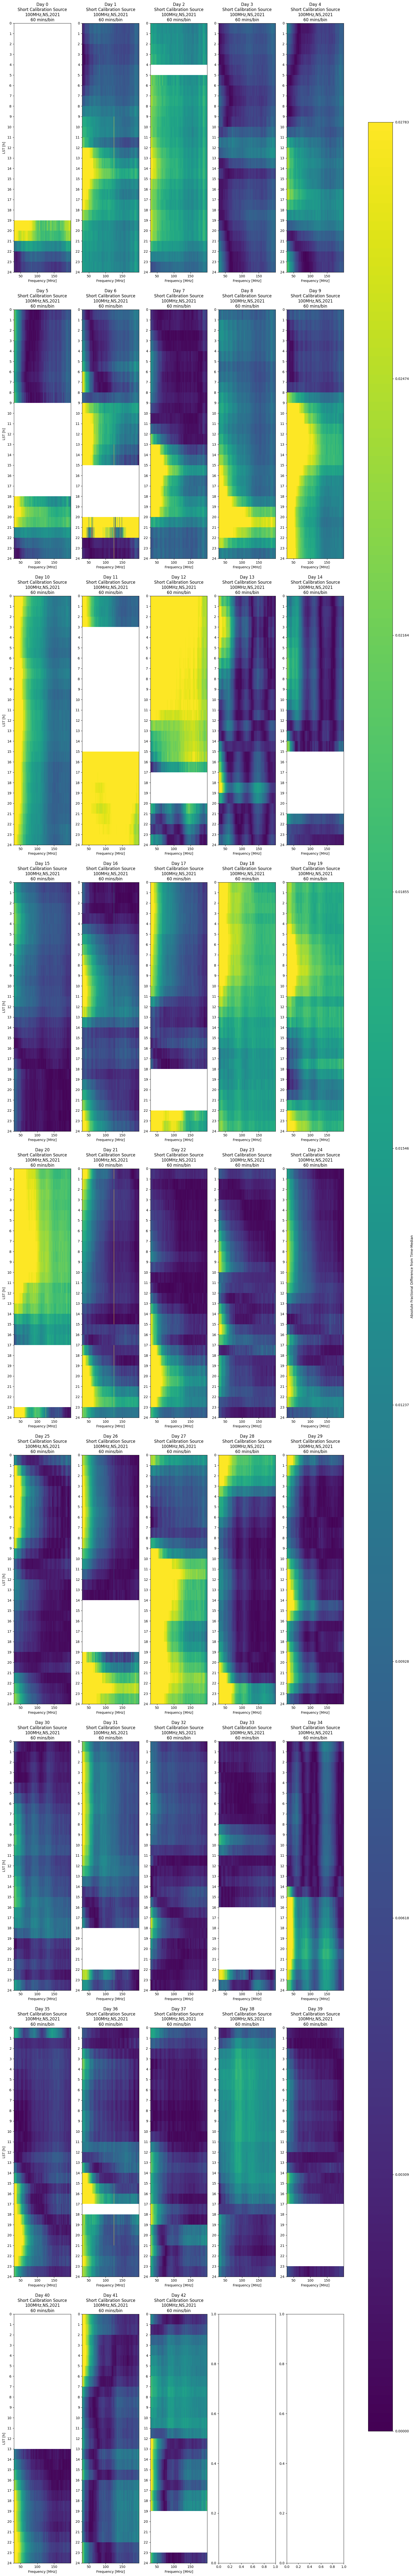

In [13]:
# Interpolated spectra waterfall plots

datashort = dataprep.shorts
lstshort = dataprep.lst

# waterfall_alldays(datashort,lstshort,freqarr,source='Short') # raw spectra

time_variation(datashort,lstshort,freqarr,source='Short',plot_type='waterfall') # variation from the mean = median absolute deviation

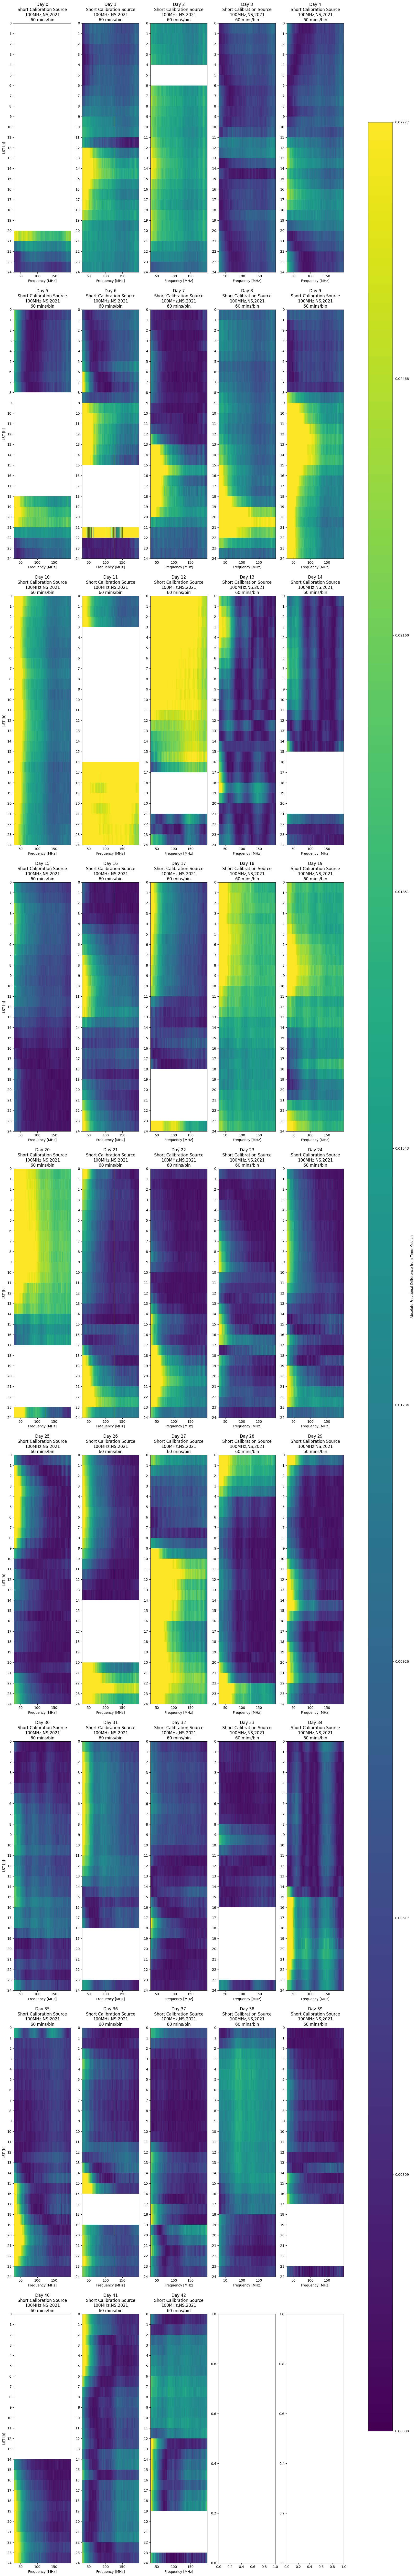

In [14]:
# Measured spectra waterfall plots
datashort_meas = dataprep.shorts_data
lstshort_meas = dataprep.shorts_data_lst


time_variation(datashort_meas,lstshort_meas,freqarr,source='Short',plot_type='waterfall') # variation from the mean = median absolute deviation

# looks the same as / similar to the interpolated one, I guess that's a good sign, and probably shows that there is only one spectra every 60 mins (so only one goes into each 60 min bin)

In [16]:
# 2D plots wrt frequency

# Prep the data
print(datashort_meas.shape)
print(lstshort_meas.shape)

# Compute median over all days, and residuals from median
time_medianshort = np.median(datashort_meas,axis=0)
res_datashort = np.abs((datashort_meas - time_medianshort)/time_medianshort)

# Split into different days
lst_splitshort, data_splitshort = LST_days_split(lstshort_meas,datashort_meas)
lst_splitshort, res_splitshort = LST_days_split(lstshort_meas,res_datashort)

n_day = 17
print(data_splitshort[n_day].shape)
print(lst_splitshort[n_day].shape)
# dimensions also check out

(10285, 4096)
(10285,)
(219, 4096)
(219,)


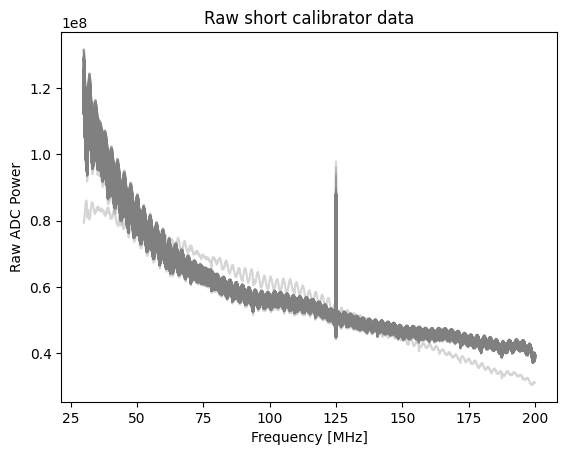

In [17]:
# Loop through days
for n_day in range(len(data_splitshort)):
    # Loop through spectra
    for i in range(data_splitshort[n_day].shape[0]):
        plt.plot(freqarr[minfreqarg:maxfreqarg],data_splitshort[n_day][i,minfreqarg:maxfreqarg],color='grey',alpha=0.05)

# plt.legend()
plt.xlabel('Frequency [MHz]')
plt.ylabel('Raw ADC Power')
plt.title('Raw short calibrator data')
plt.show()

# There's one weird spectrum but the rest seems pretty consistent
# The spike at 125 MHz is thought to be from FPGA clock leakage according to Liju Philip's thesis

day 6 LST 21.06615876702464 LSTi 158
day 6 LST 21.06800953296994 LSTi 159
day 6 LST 21.069636558409606 LSTi 160
day 6 LST 21.071492117602826 LSTi 161
day 6 LST 21.073321007855093 LSTi 162
day 6 LST 21.07496123016636 LSTi 163
day 6 LST 21.076960078901017 LSTi 164


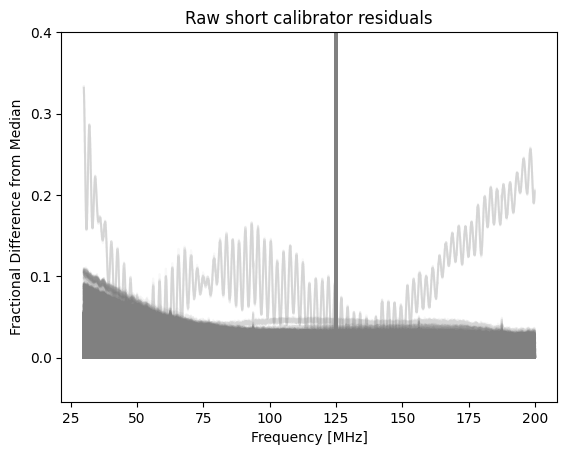

In [34]:
# Now plotting the residuals from the time median over all days
# Loop through days
for n_day in range(len(res_splitshort)):
    # Loop through spectra
    for i in range(res_splitshort[n_day].shape[0]):
        plt.plot(freqarr[minfreqarg:maxfreqarg],res_splitshort[n_day][i,minfreqarg:maxfreqarg],color='grey',alpha=0.05)
        if res_splitshort[n_day][i,minfreqarg]>0.2: print('day',n_day,'LST',lst_splitshort[n_day][i],'LSTi',i) # printing out which spectra constitute the weird one

# plt.legend()
# plt.yscale('log')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Fractional Difference from Median')
plt.title('Raw short calibrator residuals')
plt.ylim(top=0.4)
plt.show()

day 6 LST 21.06615876702464 LSTi 158
day 6 LST 21.06800953296994 LSTi 159
day 6 LST 21.069636558409606 LSTi 160
day 6 LST 21.071492117602826 LSTi 161
day 6 LST 21.073321007855093 LSTi 162
day 6 LST 21.07496123016636 LSTi 163
day 6 LST 21.076960078901017 LSTi 164


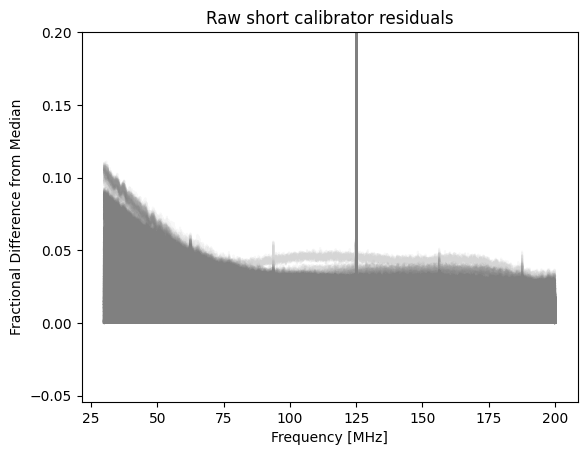

In [33]:
# Same plot but without the weird spectrum to see general trends better
# Loop through days
for n_day in range(len(res_splitshort)):
    # Loop through spectra
    for i in range(res_splitshort[n_day].shape[0]):
        if res_splitshort[n_day][i,minfreqarg] <= 0.2:
            plt.plot(freqarr[minfreqarg:maxfreqarg],res_splitshort[n_day][i,minfreqarg:maxfreqarg],color='grey',alpha=0.05)
        else: 
            print('day',n_day,'LST',lst_splitshort[n_day][i],'LSTi',i) # printing out which spectra constitute the weird one(s)

# plt.legend()
# plt.yscale('log')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Fractional Difference from Median')
plt.title('Raw short calibrator residuals')
plt.ylim(top=0.2)
plt.show()

### 2020, 100MHz, EW

do we even have 2020 data?